In [6]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import inception_v3
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [7]:
DATA_DIR = ""
# IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos/jpg")
IMAGE_DIR = os.path.join(DATA_DIR, "images")

HOLIDAY_FILE_IDS = os.path.join(DATA_DIR, "holiday-ids.txt")
HOLIDAY_VECS_FILE = os.path.join(DATA_DIR, "holiday-vecs.npy")

def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
    
def create_triples(image_dir):
    img_groups = {}
    for img_file in os.listdir(image_dir):
        if (img_file[-3:] == 'jpg'):
            prefix, suffix = img_file.split(".")
            gid, pid = prefix[0:4], prefix[4:]
            if gid in img_groups:
                img_groups[gid].append(pid)
            else:
                img_groups[gid] = [pid]
            
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triples_data = create_triples(IMAGE_DIR)

print(len(triples_data))
print(triples_data[0:5])

def load_image_cache(image_cache, image_filename):
    image = plt.imread(os.path.join(IMAGE_DIR, image_filename))
    image = imresize(image, (299, 299))
    image = image.astype("float32")
    image = inception_v3.preprocess_input(image)
    image_cache[image_filename] = image
    
image_cache = {}
num_pairs = len(triples_data)
for i, (image_filename_l, image_filename_r, _) in enumerate(triples_data):
    if i % 1000 == 0:
        print("images from {:d}/{:d} pairs loaded to cache".format(i, num_pairs))
    if image_filename_l not in image_cache:
        load_image_cache(image_cache, image_filename_l)
    if image_filename_r not in image_cache:
        load_image_cache(image_cache, image_filename_r)
print("images from {:d}/{:d} pairs loaded to cache, COMPLETE".format(i, num_pairs))

def pair_generator(triples, image_cache, datagens, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            X1 = np.zeros((batch_size, 299, 299, 3))
            X2 = np.zeros((batch_size, 299, 299, 3))
            Y = np.zeros((batch_size, 2))
            for i, (image_filename_l, image_filename_r, label) in enumerate(batch):
                if datagens is None or len(datagens) == 0:
                    X1[i] = image_cache[image_filename_l]
                    X2[i] = image_cache[image_filename_r]
                else:
                    X1[i] = datagens[0].random_transform(image_cache[image_filename_l])
                    X2[i] = datagens[1].random_transform(image_cache[image_filename_r])
                Y[i] = [1, 0] if label == 0 else [0, 1]
            yield [X1, X2], Y

3312
[('410008.jpg', '410009.jpg', 1), ('420008.jpg', '420006.jpg', 1), ('430003.jpg', '430002.jpg', 1), ('120003.jpg', '070002.jpg', 0), ('450006.jpg', '400005.jpg', 0)]
images from 0/3312 pairs loaded to cache


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


images from 1000/3312 pairs loaded to cache
images from 2000/3312 pairs loaded to cache
images from 3000/3312 pairs loaded to cache
images from 3311/3312 pairs loaded to cache, COMPLETE


In [8]:
from skimage import exposure

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

datagen_args = dict(rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    preprocessing_function=AHE,
                    fill_mode='nearest')

datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
pair_gen = pair_generator(triples_data, image_cache, datagens, 32)
[X1, X2], Y = pair_gen.__next__()
print(X1.shape, X2.shape, Y.shape)

# (32, 299, 299, 3) (32, 299, 299, 3) (32, 2)
# Define Model
# The model is composed of two pretrained Inception V3 networks without their last prediction layer, 
# connected to a merge layer that computes element-wise dot product of the two (2048,) sized vectors produced 
# by the Inception V3. This is then fed into a 3 layer fully connected network that produces the similar / not 
# similar prediction.
# The Inception V3 network weights are frozen, and the Fully Connected network weights are loaded from one trained 
# using pre-computed image vectors and allowed to be fine-tuned.
# In [6]:
# distance measure

def absdiff(vecs):
    x, y = vecs
    return K.abs(K.sum(K.stack([x, -y], axis=1), axis=1))

def absdiff_output_shape(shapes):
    return shapes[0]

# BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-best.h5")
# FINAL_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-final.h5")

(32, 299, 299, 3) (32, 299, 299, 3) (32, 2)


In [9]:
vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = absdiff(vecs)
print(s.shape)

# (10,) (10,)
# (10,)
# In [7]:
# load 2 copies of the inception model
# in case of a siamese network, the same instance of the network will be trained,
# but in our case the network is untrainable, so we can have 2 copies
inception_1 = inception_v3.InceptionV3(weights="imagenet", include_top=True)
inception_2 = inception_v3.InceptionV3(weights="imagenet", include_top=True)
# In [8]:
# Here the last two layers are avg_pool and prediction as shown below:
#    avg_pool (None, 8, 8, 2048) (None, 2048)
#    predictions (None, 2048) (None, 1000)
#
# for layer in inception_1.layers:
#     print(layer.name, layer.input_shape, layer.output_shape)
# In [9]:
# freeze weights on the inception network and give each layer a unique name
# since we will combine them into a single network
for layer in inception_1.layers:
    layer.trainable = False
    layer.name = layer.name + "_1"
for layer in inception_2.layers:
    layer.trainable = False
    layer.name = layer.name + "_2"

(10,) (10,)
(10,)


TypeError: softmax() got an unexpected keyword argument 'axis'

In [ ]:
# In [10]:
# outputs of the inception networks, these will be connected to our head FCN
vector_1 = inception_1.get_layer("avg_pool_1").output
vector_2 = inception_2.get_layer("avg_pool_2").output
# In [11]:
# load the pretrained similarity head network. This has been trained to predict similar
# images using image vectors
sim_head = load_model(os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-final_100_adam.h5"))
for layer in sim_head.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

In [ ]:
# In [12]:
# attach output of the inception networks to the similarity head
# output is a prediction tensor
prediction = sim_head([vector_1, vector_2])
# In [13]:
# declare a model that takes image inputs on its truncated Inception subnetworks
# and returns the prediction as the output. Inputs are Input(shape=(299, 299, 3))
model = Model(inputs=[inception_1.input, inception_2.input], outputs=prediction)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# Train Network
# In [14]:
BATCH_SIZE = 32
NUM_EPOCHS = 100
BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-f-best_100_args6_adam.h5")
FINAL_MODEL_FILE = os.path.join(DATA_DIR, "models", "A_A_inceptionv3-l1-f-final_100_args6_adam.h5")
# In [15]:
triples_data_trainval, triples_data_test = train_test_split(triples_data, train_size=0.8)
triples_data_train, triples_data_val = train_test_split(triples_data_trainval, train_size=0.9)
print(len(triples_data_train), len(triples_data_val), len(triples_data_test))
# 2983 332 829
# In [16]:

In [4]:
'''
# 2_A_A_inceptionv3-l1-ft-best_10.h5
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
#                     shear_range = 0.2, ###
                    zoom_range=0.2)
'''
# 2_A_A_inceptionv3-l1-ft-best_10_args2.h5

# from skimage import exposure

# def AHE(img):
#     img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
#     return img_adapteq

datagen_args = dict(# featurewise_center=True, #args5
                    # featurewise_std_normalization=True, #args5
                    featurewise_center=True,
                    rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True, #args6
#                     preprocessing_function=AHE, #args7
                    fill_mode='nearest',
                    data_format='channels_last', #args6
                    zca_whitening=False) #args6
'''
# args3
from skimage import exposure

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

datagen_args = dict(rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    preprocessing_function=AHE,
                    fill_mode='nearest')
'''
'''
# args4
datagen_args = dict(featurewise_center=True,
                    featurewise_std_normalization=True,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True)
'''

datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
train_pair_gen = pair_generator(triples_data_train, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(triples_data_val, image_cache, None, BATCH_SIZE)
# In [17]:
num_train_steps = len(triples_data_train) // BATCH_SIZE
num_val_steps = len(triples_data_val) // BATCH_SIZE
# In [18]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL_FILE, save_best_only=True)
history = model.fit_generator(train_pair_gen, 
                             steps_per_epoch=num_train_steps,
                             epochs=NUM_EPOCHS,
                             validation_data=val_pair_gen,
                             validation_steps=num_val_steps,
                             callbacks=[checkpoint])

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="blue", label="train")
plt.plot(history.history["val_acc"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# In [20]:
model.save(FINAL_MODEL_FILE, overwrite=True)
# Predictions
# In [21]:


NameError: name 'triples_data_train' is not defined

In [5]:
ImageDataGenerator?

In [8]:
def evaluate_model(model):
    ytest, ytest_ = [], []
    test_pair_gen = pair_generator(triples_data_test, image_cache, None, BATCH_SIZE)
    num_test_steps = len(triples_data_test) // BATCH_SIZE
    curr_test_steps = 0
    for [X1test, X2test], Ytest in test_pair_gen:
        if curr_test_steps > num_test_steps:
            break
        Ytest_ = model.predict([X1test, X2test])
        ytest.extend(np.argmax(Ytest, axis=1).tolist())
        ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
        curr_test_steps += 1
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    return acc, cm

In [9]:
print("==== Evaluation Results: final model on test set ====")
final_model = load_model(FINAL_MODEL_FILE)
acc, cm = evaluate_model(final_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

==== Evaluation Results: final model on test set ====
Accuracy Score: 0.990
Confusion Matrix
[[312   4]
 [  3 353]]


In [10]:
print("==== Evaluation Results: best model on test set ====")
best_model = load_model(BEST_MODEL_FILE)
acc, cm = evaluate_model(best_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)


==== Evaluation Results: best model on test set ====
Accuracy Score: 0.991
Confusion Matrix
[[322   5]
 [  1 344]]


In [20]:
image = plt.imread(os.path.join(IMAGE_DIR, '100001.jpg'))
image = imresize(image, (299, 299))
image = image.astype("float32")
image = inception_v3.preprocess_input(image)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


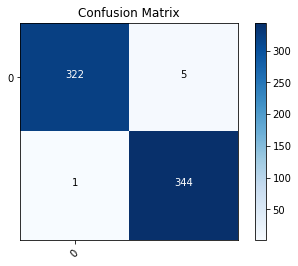

In [11]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plot_confusion_matrix(cm, range(0, 1))

In [12]:
ytest, ytest_ = [], []
test_pair_gen = pair_generator(triples_data_test, image_cache, None, BATCH_SIZE)
num_test_steps = len(triples_data_test) // BATCH_SIZE
curr_test_steps = 0
test_pair_gen

<generator object pair_generator at 0x7fb24077bf10>

In [13]:
ytest, ytest_ = [], []
i = 0
for [X1test, X2test], Ytest in test_pair_gen:
    i += 1
    print(X1test)
    if curr_test_steps > num_test_steps:
        break
    Ytest_ = best_model.predict([X1test, X2test])
    ytest.extend(np.argmax(Ytest, axis=1).tolist())
    ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
    curr_test_steps += 1
    print(ytest)
    print(ytest_)
    break

acc = accuracy_score(ytest, ytest_)
cm = confusion_matrix(ytest, ytest_)

print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

[[[[-0.89803922 -0.92941177 -0.92156863]
   [-0.89803922 -0.92941177 -0.92156863]
   [-0.89803922 -0.92941177 -0.92156863]
   ...
   [ 0.45098042  0.7019608   0.65490198]
   [ 0.45882356  0.71764708  0.66274512]
   [ 0.47450984  0.73333335  0.67843139]]

  [[-0.88235295 -0.9137255  -0.9137255 ]
   [-0.88235295 -0.9137255  -0.9137255 ]
   [-0.88235295 -0.9137255  -0.9137255 ]
   ...
   [ 0.43529415  0.67843139  0.64705884]
   [ 0.44313729  0.7019608   0.65490198]
   [ 0.45882356  0.71764708  0.67058825]]

  [[-0.85882354 -0.89019608 -0.9137255 ]
   [-0.85882354 -0.89019608 -0.9137255 ]
   [-0.86666667 -0.89803922 -0.9137255 ]
   ...
   [ 0.41176474  0.65490198  0.63921571]
   [ 0.42745101  0.67843139  0.65490198]
   [ 0.44313729  0.69411767  0.67058825]]

  ...

  [[-0.04313725 -0.01960784 -0.09019607]
   [-0.05882353 -0.03529412 -0.13725489]
   [-0.06666666 -0.04313725 -0.1607843 ]
   ...
   [ 0.05882359 -0.20784312 -0.53725493]
   [ 0.082353   -0.18431371 -0.50588238]
   [ 0.12156868 

[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Accuracy Score: 1.000
Confusion Matrix
[[14  0]
 [ 0 18]]
